# Data Analysis and Cleaning

## Preliminary Observations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
from sklearn.model_selection import GroupShuffleSplit


pd.options.future.infer_string = True
pd.options.mode.copy_on_write = True
pd.options.display.max_rows = 200
sns.set_theme()

In [2]:
data = pd.read_parquet("../data/source.parquet")
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 5152489 entries, 9 to 140000054
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   manufacturer       5152489 non-null  string 
 1   brand              5152489 non-null  string 
 2   model              5152489 non-null  string 
 3   mass_kg            5152426 non-null  float64
 4   fuel_type          5152489 non-null  string 
 5   fuel_mode          5152489 non-null  string 
 6   engine_size_cm3    5152482 non-null  float64
 7   engine_power_kw    5149121 non-null  float64
 8   fuel_cons_l_100km  5152489 non-null  float64
dtypes: float64(4), string(5)
memory usage: 556.5 MB


NULL values only occur among the numerical measurements. Vehicle mass and engine size are NULL for a negligible number of records (approximately 0.001% of the data) and we don't see much value in imputing them, hence we will drop the records entirely.

Engine power also happens to be NULL quite rarely, and given the large size of the dataset, we could discard the corresponding records as well. However, there is some value in being able to make predictions when such information is missing, as one could know the size of the engine without knowing its power. Hence, we retain NULL engine size values as they are, and we will determine the most appropriate imputation strategy when we build the machine learning models.

In [3]:
data = data.dropna(subset=['mass_kg', 'engine_size_cm3'])
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 5152419 entries, 9 to 140000054
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   manufacturer       5152419 non-null  string 
 1   brand              5152419 non-null  string 
 2   model              5152419 non-null  string 
 3   mass_kg            5152419 non-null  float64
 4   fuel_type          5152419 non-null  string 
 5   fuel_mode          5152419 non-null  string 
 6   engine_size_cm3    5152419 non-null  float64
 7   engine_power_kw    5149051 non-null  float64
 8   fuel_cons_l_100km  5152419 non-null  float64
dtypes: float64(4), string(5)
memory usage: 559.5 MB


In [4]:
data.head(10)

,manufacturer,brand,model,mass_kg,fuel_type,fuel_mode,engine_size_cm3,engine_power_kw,fuel_cons_l_100km
id,,,,,,,,,
9,RENAULT-NISSAN-MITSUBISHI,MITSUBISHI MOTORS THAILAND,MITSUBISHI SPACE STAR,940.0,petrol,M,1193.0,52.0,5.0
18,RENAULT-NISSAN-MITSUBISHI,MITSUBISHI MOTORS THAILAND,MITSUBISHI SPACE STAR,940.0,petrol,M,1193.0,52.0,5.0
19,RENAULT-NISSAN-MITSUBISHI,MITSUBISHI MOTORS THAILAND,MITSUBISHI SPACE STAR,940.0,petrol,M,1193.0,52.0,5.0
80,RENAULT-NISSAN-MITSUBISHI,MITSUBISHI MOTORS THAILAND,MITSUBISHI SPACE STAR,950.0,petrol,M,1193.0,52.0,5.1
85,RENAULT-NISSAN-MITSUBISHI,MITSUBISHI MOTORS THAILAND,MITSUBISHI SPACE STAR,940.0,petrol,M,1193.0,52.0,5.0
86,RENAULT-NISSAN-MITSUBISHI,MITSUBISHI MOTORS THAILAND,MITSUBISHI SPACE STAR,950.0,petrol,M,1193.0,52.0,5.1
110,RENAULT-NISSAN-MITSUBISHI,MITSUBISHI MOTORS THAILAND,MITSUBISHI SPACE STAR,950.0,petrol,M,1193.0,52.0,5.1
113,RENAULT-NISSAN-MITSUBISHI,MITSUBISHI MOTORS THAILAND,MITSUBISHI SPACE STAR,940.0,petrol,M,1193.0,52.0,5.0
127,RENAULT-NISSAN-MITSUBISHI,MITSUBISHI MOTORS THAILAND,MITSUBISHI SPACE STAR,985.0,petrol,M,1193.0,52.0,5.5


As discussed in the previous notebook, we see many different registrations for each car. Hence, many measurements are available for each car configuration, facilitating outlier detection and data cleaning.

However, there is also a significant drawback: since nothing prevents us from splitting observations of the same car into different groups, we could easily end up performing hyperparameter tuning and model evaluation with data that was previously seen while training the model, which obviously leads to overfitting. To avoid this, special care needs to be taken when splitting the data.

We will split the data based on groups: cars with the same configurations will fall into the same group, and the data will be split in a way that doesn't divide observations belonging to the same group. This ensures that validation data and testing data are truly unseen before. Scikit-learn conveniently provides [tools to deal with grouped data](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators-for-grouped-data), so the question now is: how do we group our data?

A naive idea would be to group by brand and model. However, just a few examples make it immediately clear that car manufacturers frequently give different names to models that are roughly the same in terms of technical characteristics. For instance, the Audi A4 and A5 have approximately the same size and share the same engines, but they are named differently because the former is a station wagon (in its most popular version) while the latter is a coupé.

In [5]:
data[
    (data.brand == "AUDI") & data.model.str.startswith(("A4", "A5"))
].sort_values(by=['engine_size_cm3', 'engine_power_kw']).tail()

,manufacturer,brand,model,mass_kg,fuel_type,fuel_mode,engine_size_cm3,engine_power_kw,fuel_cons_l_100km
id,,,,,,,,,
134108346,VOLKSWAGEN,AUDI,A5 SPORTBACK,1644.0,petrol,M,1984.0,150.0,6.8
134108384,VOLKSWAGEN,AUDI,A5 SPORTBACK,1620.0,petrol,M,1984.0,150.0,6.6
134108539,VOLKSWAGEN,AUDI,A4 AVANT,1636.0,petrol,M,1984.0,150.0,6.4
127257939,VOLKSWAGEN,AUDI,A4 AVANT,1741.0,petrol,M,1984.0,195.0,7.8
127340274,VOLKSWAGEN,AUDI,A5 SPORTBACK,1670.0,petrol,M,1984.0,195.0,7.8


The same can be said for similar cars by the same manufacturer, even if they are sold under a different brand. Continuing the example above, we could argue that this is the case for the Volkswagen Passat.

In [6]:
data[
    (data.brand == "VOLKSWAGEN") & (data.model == "PASSAT")
    & (data.engine_size_cm3 == 1984.0)
].head()

,manufacturer,brand,model,mass_kg,fuel_type,fuel_mode,engine_size_cm3,engine_power_kw,fuel_cons_l_100km
id,,,,,,,,,
96667417,VOLKSWAGEN,VOLKSWAGEN,PASSAT,1726.0,petrol,M,1984.0,206.0,8.7
96667420,VOLKSWAGEN,VOLKSWAGEN,PASSAT,1709.0,petrol,M,1984.0,206.0,8.4
96667422,VOLKSWAGEN,VOLKSWAGEN,PASSAT,1573.0,petrol,M,1984.0,140.0,7.3
96667424,VOLKSWAGEN,VOLKSWAGEN,PASSAT,1538.0,petrol,M,1984.0,140.0,7.0
96667434,VOLKSWAGEN,VOLKSWAGEN,PASSAT,1564.0,petrol,M,1984.0,140.0,7.3


Furthermore, it should be noted that quite often the same car model is reported under multiple different names (as in the example below), and given the size of the dataset, it would be too time-consuming to amend all the entries manually.

In [7]:
data.loc[(data.brand == "ALFA ROMEO") & data.model.str.endswith("GIULIA"), 'model'].unique()

<ArrowStringArrayNumpySemantics>
['GIULIA', 'ALFA GIULIA']
Length: 2, dtype: string

A much better idea is to group the data by manufacturer and engine. This way, we ensure that the many different variations of trims and configurations that can be made on some vehicle will all fall into the same group. Precisely, then, we will group using the columns `manufacturer` and `engine_size_cm3` (we could also include other variables, but we prefer to be more conservative).

In order for this strategy to work, however, we need to make sure that:

1. the manufacturers are specified consistently among the different observations;
2. all the features needed for grouping are never NULL.

The second condition is already respected, because we have dropped all the records in which the engine size was NULL. In the next section we take care of cleaning the data to make sure that the first condition is met as well.

## Brand and Manufacturer Corrections

In [8]:
sorted(data.manufacturer.unique())

['',
 'BMW',
 'FORD',
 'HYUNDAI MOTOR EUROPE',
 'KG MOBILITY GREAT WALL MOTOR',
 'KIA',
 'MAZDA',
 'MERCEDES-BENZ AG',
 'RENAULT-NISSAN-MITSUBISHI',
 'STELLANTIS',
 'SUBARU-SUZUKI-TOYOTA',
 'VOLKSWAGEN']

In [9]:
data[data.manufacturer == ""]

,manufacturer,brand,model,mass_kg,fuel_type,fuel_mode,engine_size_cm3,engine_power_kw,fuel_cons_l_100km
id,,,,,,,,,
90240427,,CHEVROLET,CORVETTE,1767.0,petrol,M,6162.0,354.0,12.1
90275524,,AUDI,TT COUPE,1480.0,petrol,M,1984.0,180.0,8.0
90280194,,RENAULT,CLIO,1165.0,petrol,M,999.0,74.0,5.7
90286017,,OPEL,MOVANO,2140.0,diesel,M,2179.0,103.0,11.0
90286018,,FIAT,SCUDO,2140.0,diesel,M,1997.0,106.0,8.0
...,...,...,...,...,...,...,...,...,...
134598912,,ASTON MARTIN,V12 VANTAGE ROADSTER,1930.0,petrol,M,5204.0,515.0,13.9
134598969,,LAND ROVER,RANGE ROVER,2725.0,petrol,M,4395.0,390.0,11.9
134599438,,VOLVO,XC40,1625.0,petrol,M,1477.0,95.0,7.4


After printing out the list of car manufacturers, we see that there are no misspelled values, but unfortunately a good number of cars have an empty string as manufacturer. We can correct them by assigning the value of the manufacturer based on the brand. For instance, we know that Audi belongs to the Volkswagen group, Fiat to Stellantis, and so on. That, however, requires that the car brands be specified consistently, so let's check if that is the case.

In [10]:
sorted(data.brand.unique())

['ABARTH',
 'ALFA ROMEO',
 'ALLIED VEHICLES LTD',
 'ALPINA',
 'ALPINE',
 'ASTON MARTIN',
 'AUDI',
 'AUTOMOBILI LAMBORGHINI S',
 'AUTOMOBILI LAMBORGHINI SPA',
 'BAIC',
 'BENTLEY',
 'BMW',
 'BMW ALPINA',
 'BUGATTI',
 'BUSINVEST',
 'CADILLAC',
 'CASELANI',
 'CATERHAM',
 'CATERHAM CARS LIMITED',
 'CHERVOLET',
 'CHERY',
 'CHEVROLET',
 'CITROEN',
 'CITROEN GIOTTILINE',
 'CITROEN/ SUN LIVING',
 'CITROEN/ADRIA',
 'CITROEN/CAPRON',
 'CITROEN/CLEVER',
 'CITROEN/DETHLEFFS',
 'CITROEN/HOBBY',
 'CITROEN/POESSL',
 'CITROENDS',
 'CUBY',
 'CUPRA',
 'DACIA',
 'DALLARA',
 'DETHLEFFS',
 'DFSK',
 'DONKERVOORT',
 'DR',
 'DS',
 'ETRUSCO',
 'EURA MOBIL',
 'FERRARI',
 'FIAT',
 'FIAT/ ETRUSCO',
 'FIAT/ ILUSION',
 'FIAT/ WEINSBERG',
 'FIAT/ADRIA',
 'FIAT/AUTOSTAR',
 'FIAT/BENIMAR',
 'FIAT/CAPRON',
 'FIAT/CARTHAGO',
 'FIAT/CHAUSSON',
 'FIAT/DETHLEFFS',
 'FIAT/EURA MOBIL',
 'FIAT/GLOBE-TRAVELLER',
 'FIAT/HOBBY',
 'FIAT/KNAUS',
 'FIAT/LAIKA',
 'FIAT/LMC',
 'FIAT/POESSL',
 'FIAT/RANDGER',
 'FIAT/RIMOR',
 'FIAT/ROLL

In [11]:
data[data.brand == "SIN MARCA"]

,manufacturer,brand,model,mass_kg,fuel_type,fuel_mode,engine_size_cm3,engine_power_kw,fuel_cons_l_100km
id,,,,,,,,,
123675383,STELLANTIS,SIN MARCA,5008 GT PURETECH 130 S&S 6 VEL MAN,1504.0,petrol,M,1199.0,96.0,6.3


We see a lot of brand pairs, such as "FIAT/ WEINSBERG", "FIAT/RANDGER", "FORD/ RANDGER", "VOLKWAGEN/WEINSBERG". The latter brands adapt models from the former as vans and campers. When they do this, they often change the model name; for instance, the WEINSBERG CaraCompact is a campervan based on the FIAT Ducato.

In order to make sure our grouping is consistent, we could populate the manufacturer column with the name of the original manufacturer of the vehicle. However, there is not much use in keeping all these vehicles in our dataset, considering that the scope of our work is to estimate fuel consumption of passenger cars. Hence, we will discard them entirely.

In [12]:
brands_to_remove = [
    "ALLIED VEHICLES LTD",
    "BUSINVEST",
    "CITROEN GIOTTILINE", "CITROEN/ SUN LIVING", "CITROEN/ADRIA", "CITROEN/CAPRON",
    "CITROEN/CLEVER", "CITROEN/DETHLEFFS", "CITROEN/HOBBY", "CITROEN/POESSL",
    "CUBY",
    "DETHLEFFS",
    "ETRUSCO",
    "EURA MOBIL",
    "FIAT/ ETRUSCO", "FIAT/ ILUSION", "FIAT/ WEINSBERG", "FIAT/ADRIA", "FIAT/AUTOSTAR",
    "FIAT/BENIMAR", "FIAT/CAPRON", "FIAT/CARTHAGO", "FIAT/CHAUSSON", "FIAT/DETHLEFFS",
    "FIAT/EURA MOBIL", "FIAT/GLOBE-TRAVELLER", "FIAT/HOBBY", "FIAT/KNAUS", "FIAT/LAIKA",
    "FIAT/LMC", "FIAT/POESSL", "FIAT/RANDGER", "FIAT/RIMOR", "FIAT/ROLLER TEAM", "FIAT/SUNLIVING",
    "FORD/ RANDGER", "FORD/ALLIED VEHICLES", "FORD/BENIMAR", "FORD/CHAUSSON", "FORD/ETRUSCO",
    "FORD/GIOTTILINE", "FORD/WEINSBERG",
    "HOBBY",
    "ILES AUTOMOTIVE",
    "IVECO/CARPOL",
    "KNAUS",
    "MAN/KNAUS",
    "MERCEDES-BENZ/KABE", "MERCEDES-BENZ/WEINSBERG",
    "OLMEDO",
    "PEUGEOT/DETHLEFFS", "PEUGEOT/GIOTTILINE",
    "POESSL",
    "RENAULT/AHORN", "RENAULT/CARPOL",
    "SPRINTCAR",
    "VOLKSWAGEN ALLIED VEHICLES", "VOLKSWAGEN API", "VOLKSWAGEN/GLOBE-TRAVELLER",
    "VOLKSWAGEN/KNAUS", "VOLKWAGEN/WEINSBERG"
]
data = data[~data.brand.isin(brands_to_remove)]

brands_to_rename = {
    "AUTOMOBILI LAMBORGHINI S": "LAMBORGHINI",
    "AUTOMOBILI LAMBORGHINI SPA": "LAMBORGHINI",
    "BMW ALPINA": "ALPINA",
    "CATERHAM CARS LIMITED": "CATERHAM",
    "CHERVOLET": "CHEVROLET",
    "CITROENDS": "CITROEN",
    "FORD (D)": "FORD",
    "FORD (USA)": "FORD",
    "FORD-CNG TECHNIK": "FORD",
    "MC LAREN": "MCLAREN",
    "MERCEDES" :"MERCEDES-BENZ",
    "MERCEDES AMG": "MERCEDES-AMG",
    "MERCEDES BENZ": "MERCEDES-BENZ",
    "MG": "MG ROEWE",
    "MGROEWE": "MG ROEWE",
    "MITSUBISHI MOTORS THAILAND": "MITSUBISHI",
    "OPELVAUXHALL": "OPEL",
    "PORSCHE 911": "PORSCHE",
    "ROLLS ROYCE": "ROLLS-ROYCE",
    "SAANGYONG": "SSANGYONG",
    "SIN MARCA": "PEUGEOT",
    "SITROENDS": "CITROEN",
    "SSANG YONG": "SSANGYONG",
    "SSNGYONG": "SSANGYONG",
    "TOYOTA AVESTARK": "TOYOTA",
    "VOLKSWAGEN AG": "VOLKSWAGEN",
    "VOLKSWAGEN V W": "VOLKSWAGEN",
    "VOLKSWAGEN VW": "VOLKSWAGEN",
    "VOLKSWAGENVW": "VOLKSWAGEN",
    "VOLKSWAGEN`": "VOLKSWAGEN",
    "VW": "VOLKSWAGEN"
}
data.brand = data.brand.replace(brands_to_rename)

In [13]:
brands = (
    data[['brand', 'manufacturer']].drop_duplicates()
    .sort_values(by=['brand', 'manufacturer'], ignore_index=True)
    .replace("", None)
)
brands.head(10)

,brand,manufacturer
0,ABARTH,STELLANTIS
1,ALFA ROMEO,NaN
2,ALFA ROMEO,STELLANTIS
3,ALPINA,NaN
4,ALPINE,NaN
5,ALPINE,RENAULT-NISSAN-MITSUBISHI
6,ASTON MARTIN,NaN
7,AUDI,NaN
8,AUDI,VOLKSWAGEN
9,BAIC,NaN


We can now use the cleaned brand data to populate the missing manufacturer data. Our strategy is as follows:

1. For brands having exactly one nonempty string as manufacturer, the manufacturer column will be populated with such string. This is the case of brands having the correct manufacturer in all the records (for example, Abarth), and also the case of brands having the correct manufacturer in some records and the empty string in other records (for example, Audi).
2. In all the other cases, that are brands not having any nonempty manufacturer (for example, Aston Martin) and brands having multiple nonempty manufacturers, corrections will need to be evaluated on a case-by-case basis.

In [14]:
case_1 = brands.groupby('brand').manufacturer.transform('count') == 1
brands_1 = brands[case_1].groupby('brand').manufacturer.first(skipna=True)
brands_1.head()

brand
ABARTH                       STELLANTIS
ALFA ROMEO                   STELLANTIS
ALPINE        RENAULT-NISSAN-MITSUBISHI
AUDI                         VOLKSWAGEN
BENTLEY                      VOLKSWAGEN
Name: manufacturer, dtype: string

In [15]:
case_2 = ~case_1
brands_2 = brands[case_2].set_index('brand').manufacturer
brands_2

brand
ALPINA                                NaN
ASTON MARTIN                          NaN
BAIC                                  NaN
BUGATTI                               NaN
CADILLAC                              NaN
CATERHAM                              NaN
CHERY                                 NaN
CHEVROLET                             NaN
DALLARA                               NaN
DFSK                                  NaN
DONKERVOORT                           NaN
DR                                    NaN
DS                                    NaN
DS              RENAULT-NISSAN-MITSUBISHI
DS                             STELLANTIS
FERRARI                               NaN
FORTHING                              NaN
GEELY                                 NaN
GMC                                   NaN
HONDA                                 NaN
INEOS                                 NaN
JAC                                   NaN
JAGUAR                                NaN
KTM                         

In [16]:
brands_2.loc["ALPINA"] = "BMW"
brands_2.loc[["CADILLAC", "CHEVROLET", "GMC"]] = "GENERAL MOTORS"
brands_2.loc["DFSK"] = "SERES"
brands_2.loc[["DS", "MASERATI"]] = "STELLANTIS"
brands_2.loc["FORTHING"] = "DONGFENG MOTOR"
brands_2.loc[["JAGUAR", "LAND ROVER"]] = "JAGUAR LAND ROVER"
brands_2.loc[["LOTUS", "VOLVO"]] = "GEELY"
brands_2.loc["MAN"] = "VOLKSWAGEN"
brands_2.loc["MG ROEWE"] = "SAIC"
brands_2.loc["SPORTEQUIPE"] = "DR"
brands_2.loc["SWM"] = "SHINERAY"

na_values = brands_2.isna()
brands_2[na_values] = brands_2[na_values].index

brands_2 = brands_2[~brands_2.index.duplicated()]
brands_2.head()

brand
ALPINA                     BMW
ASTON MARTIN      ASTON MARTIN
BAIC                      BAIC
BUGATTI                BUGATTI
CADILLAC        GENERAL MOTORS
Name: manufacturer, dtype: string

In [17]:
brands = pd.concat([brands_1, brands_2])
data = data.drop(columns='manufacturer').join(brands, on='brand').reindex_like(data)

Let's finally display the result of our data cleaning procedures.

In [18]:
display(
    data[['manufacturer', 'brand']].drop_duplicates()
    .sort_values(by=['manufacturer', 'brand'], ignore_index=True)
)
data.info(show_counts=True)

,manufacturer,brand
0,ASTON MARTIN,ASTON MARTIN
1,BAIC,BAIC
2,BMW,ALPINA
3,BMW,BMW
4,BMW,MINI
5,BMW,ROLLS-ROYCE
6,BUGATTI,BUGATTI
7,CATERHAM,CATERHAM
8,CHERY,CHERY
9,DALLARA,DALLARA


<class 'pandas.core.frame.DataFrame'>
Index: 5151669 entries, 9 to 140000054
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   manufacturer       5151669 non-null  string 
 1   brand              5151669 non-null  string 
 2   model              5151669 non-null  string 
 3   mass_kg            5151669 non-null  float64
 4   fuel_type          5151669 non-null  string 
 5   fuel_mode          5151669 non-null  string 
 6   engine_size_cm3    5151669 non-null  float64
 7   engine_power_kw    5148301 non-null  float64
 8   fuel_cons_l_100km  5151669 non-null  float64
dtypes: float64(4), string(5)
memory usage: 557.9 MB


## Exploratory Data Analysis

We now perform some exploratory data analysis, starting by plotting pairwise relationships among numerical columns. Since the dataset is very large (approximately 5 million rows), plotting the entire data would be computationally expensive and the resulting graphs would be hardly interpretable. Therefore, we restrict the analysis to a sample of 1% of the data (approximately 50 thousand rows).

In [19]:
sample = data.sample(frac=0.01, random_state=123)
sample.head()

,manufacturer,brand,model,mass_kg,fuel_type,fuel_mode,engine_size_cm3,engine_power_kw,fuel_cons_l_100km
id,,,,,,,,,
134348412,RENAULT-NISSAN-MITSUBISHI,RENAULT,MEGANE,1415.0,petrol,M,1332.0,103.0,6.0
133144551,VOLKSWAGEN,VOLKSWAGEN,T-ROC,1546.0,petrol,M,1498.0,110.0,6.4
124192638,VOLKSWAGEN,VOLKSWAGEN,POLO,1165.0,petrol,M,999.0,70.0,5.2
122344117,STELLANTIS,PEUGEOT,308,1385.0,petrol,M,1199.0,96.0,5.6
115492598,VOLKSWAGEN,SEAT,IBIZA,1168.0,petrol,M,999.0,70.0,5.6


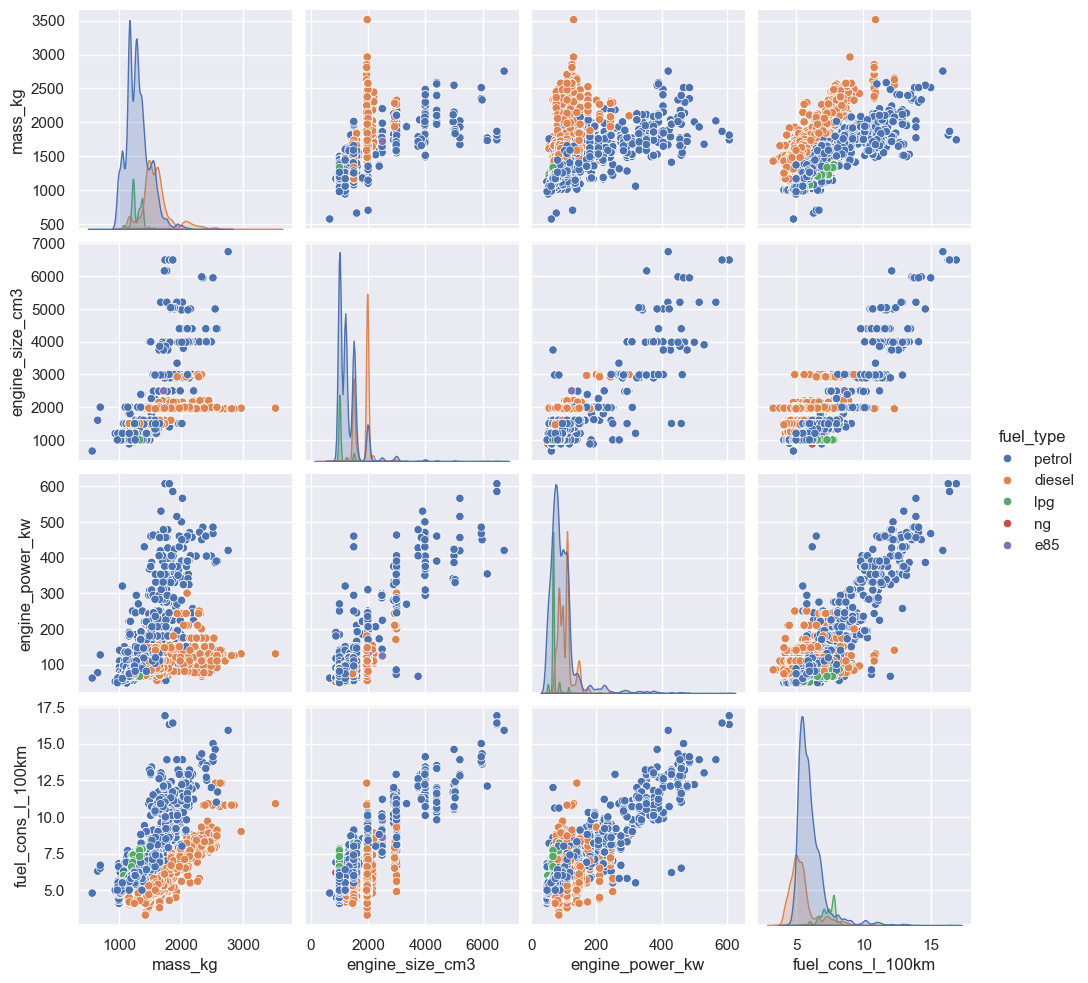

In [20]:
sns.pairplot(sample, hue='fuel_type');

We list some observations that can be made from the above, indicating in square parentheses what plots we are referring to (for instance, [3, 2] refers to the second plot of the third row, that is engine size against engine power).

- All the variable pairs show positive correlation. In particular, each variable is positively correlated with fuel consumption.
- The better fuel efficiency of the diesel cycle with respect to petrol [4, 4] seems to be at least partially offset by the fact that diesel engines tend to be installed in heavier vehicles [1, 1]. Nevertheless, at each given weight, petrol cars show an evidently higher consumption than diesel cars [4, 1].
- Engine size is a fairly discretized variable, as car makers tend to use standard sizes such as 1500, 2000, or 2500 cm3 [2, 2].
- Engine power seems to be more concentrated towards the mean for diesel cars, while the distribution for petrol cars shows more spread out spikes [3, 3]. This is consistent with the car industry in Europe, which tends to use petrol for small and cheap engines, but also for high performance sports cars.
- While very powerful cars are unequivocally characterized by high fuel consumption, the trend is more difficult to grasp at the lower end of the scale [4, 3]. Field knowledge suggests that very undersized engines behave worse in terms of fuel consumption than more powerful ones.
- Some pairs display significantly different patterns between petrol and diesel engines. Hence, a linear model will surely benefit from one-hot encoding the fuel type feature. Interactions with numerical features can also be evaluated.

Acting on our last remarks, we now plot linear regression lines of fuel consumptions with respect to mass, engine size, and engine power. The aim here is to better evaluate whether the relationship is approximately linear, or rather higher-order interpolation is necessary, especially for the smaller values.

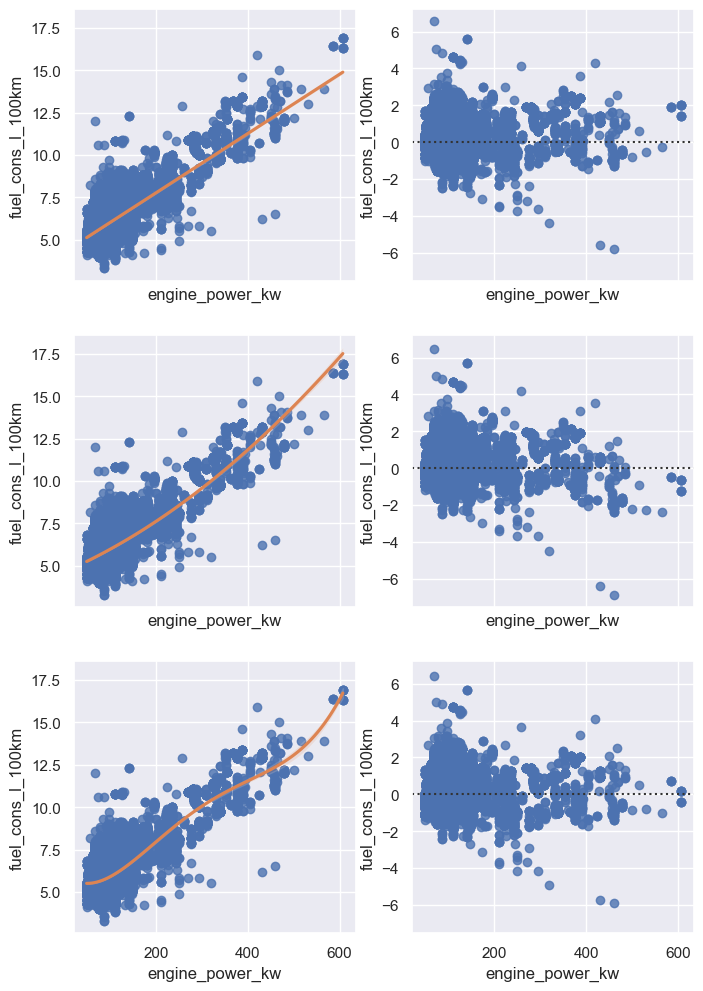

In [21]:
orders = [1, 2, 5]
fig, ax = plt.subplots(len(orders), 2, sharex='all', sharey='col', figsize=[4*2, 4*len(orders)])
for index, order in enumerate(orders):
    sns.regplot(sample, x='engine_power_kw', y='fuel_cons_l_100km',
                order=order, line_kws={'color': 'C1'}, ax=ax[index, 0])
    sns.residplot(sample, x='engine_power_kw', y='fuel_cons_l_100km',
                  order=order, ax=ax[index, 1])

Unfortunately, higher order interpolation doesn't seem to improve significantly the regression. This suggests that linear models might not predict accurately the fuel consumption of less powerful cars. However, let's postpone our judgement until we actually train the full linear models with all the variables.

Let's now investigate whether both the variables fuel type and fuel mode are useful for predicting fuel consumption, or if one of them would probably suffice instead. For this purpose, for each fuel type we compare the distributions of fuel consumption obtained with each fuel mode.

In [22]:
data[['fuel_type', 'fuel_mode']].value_counts()

fuel_type  fuel_mode
petrol     M            3572778
diesel     M            1273022
lpg        B             291208
e85        F               7273
ng         M               4821
           B               2484
lpg        M                 83
Name: count, dtype: int64

Petrol, diesel, and E85 engines only have one fuel mode each, hence we only make the comparison for natural gas and liquefied petroleum gas engines.

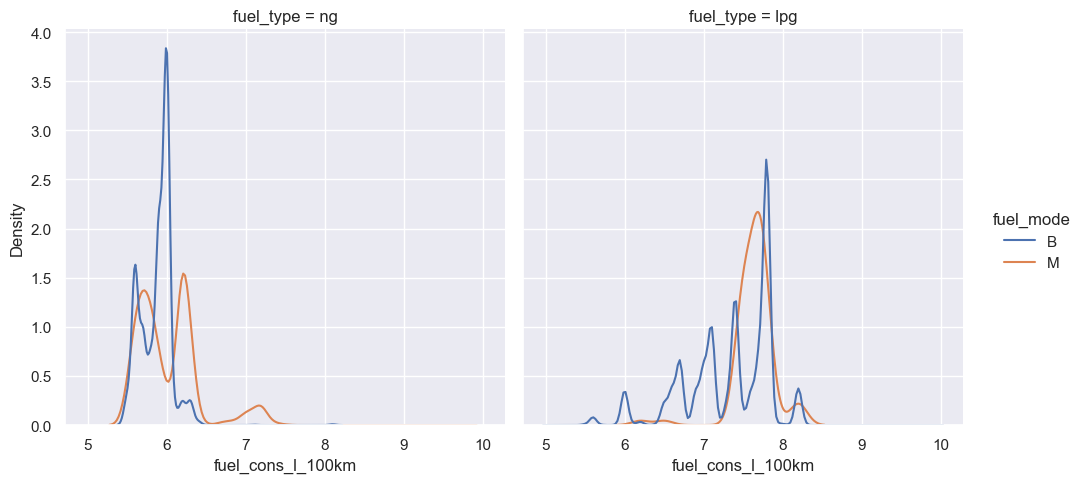

In [23]:
sns.displot(
    data[data.fuel_type.isin(["ng", "lpg"])], x='fuel_cons_l_100km',
    hue='fuel_mode', col='fuel_type', kind='kde', common_norm=False
);

Formally, what we are doing here is testing whether fuel mode and fuel consumption are conditionally independent given the fuel type. Let's check this quantitatively as well, using the two-sample Kolmogorov-Smirnov test.

In [24]:
for fuel_type in ["ng", "lpg"]:
    result = kstest(
        data.loc[(data.fuel_type == fuel_type) & (data.fuel_mode == "B"), 'fuel_cons_l_100km'],
        data.loc[(data.fuel_type == fuel_type) & (data.fuel_mode == "M"), 'fuel_cons_l_100km']
    )
    print(f"p-value for {fuel_type}: {result.pvalue}")

p-value for ng: 9.386307756636042e-218
p-value for lpg: 5.740672056938868e-22


The shapes of the kernel density estimates are quite dissimilar, and indeed the p-values indicate a very strong evidence of the distributions being different. However, at least visually the mass seems concentrated similarly, and the mismatched spikes might be further emphasized by the fact that the cardinalities of the groups are not always comparable. All in all, we might conclude that there's a modest evidence of fuel mode being relevant. In any case, we will test again when training machine learning models in the next notebooks.

## Outlier Detection

At this point, to complete the data cleaning activities, we would like to detect obvious errors in the data, such as cars that can travel 100 km with less than a liter of fuel.

Given the size and nature of our dataset, we don't find it convenient to apply outlier detection algorithms. Indeed, it would be very expensive to fit them, and they would likely report a very high number of false positives, for example on high performance sports cars.

Hence, we limit ourselves to detecting outliers on each feature separately, by means of a graphical procedure. We use Seaborn's boxen plot, which is an enhanced box plot for larger datasets.

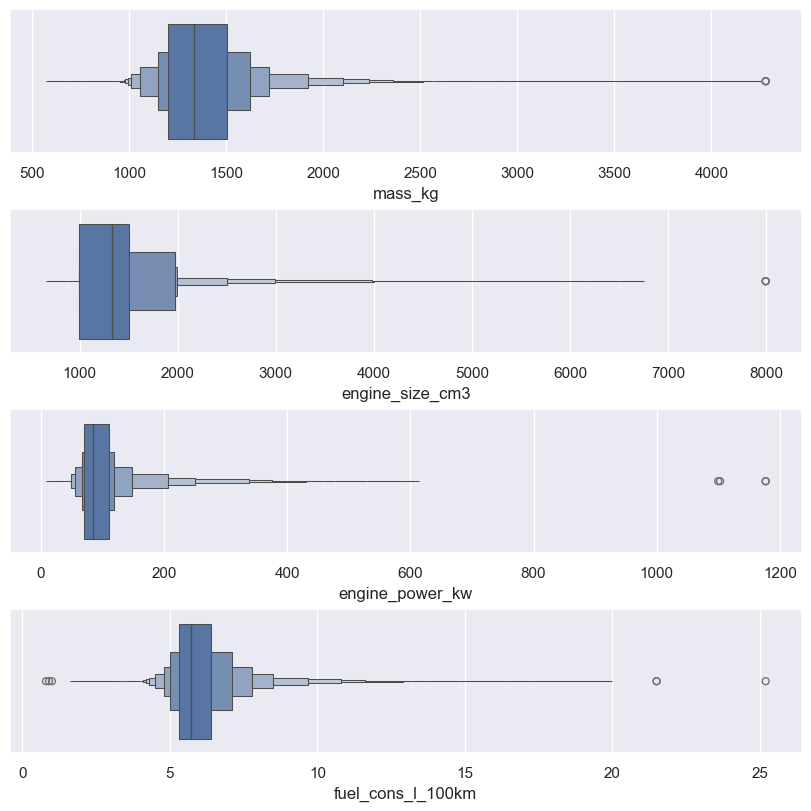

In [25]:
num_cols = data.select_dtypes(include='number').columns
fig, ax = plt.subplots(len(num_cols), figsize=[8, 2*len(num_cols)], layout='constrained')
for index, column in enumerate(num_cols):
    sns.boxenplot(data, x=column, ax=ax[index])

We now inspect each feature individually, based on the outliers identified in the above graphs.

In [26]:
data[data.mass_kg > 4200]

,manufacturer,brand,model,mass_kg,fuel_type,fuel_mode,engine_size_cm3,engine_power_kw,fuel_cons_l_100km
id,,,,,,,,,
100699148,MERCEDES-BENZ AG,MERCEDES-BENZ,S 680 4MATIC,4255.0,petrol,M,5980.0,450.0,20.0
133139220,MERCEDES-BENZ AG,MERCEDES-BENZ,S 680 4MATIC,4255.0,petrol,M,5980.0,450.0,20.0
133165406,MERCEDES-BENZ AG,MERCEDES-BENZ,S 680 4MATIC,4255.0,petrol,M,5980.0,450.0,20.0
133170417,MERCEDES-BENZ AG,MERCEDES-BENZ,S 680 4MATIC,4255.0,petrol,M,5980.0,450.0,20.0
133937207,VOLKSWAGEN,MAN,TGE,4280.0,diesel,M,1968.0,130.0,13.5
133986179,VOLKSWAGEN,MAN,TGE,4280.0,diesel,M,1968.0,130.0,13.5
134023351,VOLKSWAGEN,MAN,TGE,4280.0,diesel,M,1968.0,130.0,13.5


The MAN TGE is a van that may carry significant weight, and the above three models may be specific configurations with a particularly high mass. The weight of the Mercedes-Benz S 680, on the other hand, seems definitely off, especially when compared with other registrations of the same model.

In [27]:
data[(data.brand == "MERCEDES-BENZ") & (data.model.str.contains("S 680"))].head(3)

,manufacturer,brand,model,mass_kg,fuel_type,fuel_mode,engine_size_cm3,engine_power_kw,fuel_cons_l_100km
id,,,,,,,,,
95363252,MERCEDES-BENZ AG,MERCEDES-BENZ,S 680 MAYBACH,2330.0,petrol,M,5980.0,450.0,14.2
95363253,MERCEDES-BENZ AG,MERCEDES-BENZ,S 680 MAYBACH,2330.0,petrol,M,5980.0,450.0,13.6
96659119,MERCEDES-BENZ AG,MERCEDES-BENZ,S 680 MAYBACH,2330.0,petrol,M,5980.0,450.0,13.5


However, in the outlier registrations the fuel consumption is also higher, and it seems improbable that they were all inserted with the same incorrect data. After some Internet research, we conclude these are registrations of the [Mercedes-Benz S 680 GUARD 4MATIC](https://www.mercedes-benz.com/en/vehicles/guard/), a special protection vehicle which can withstand bullets and explosives, whose declared fuel consumption is 20 l/100 km just like in the above registrations.

Since here no correction was necessary, we move to the outliers on the engine size and power.

In [28]:
data[(data.engine_size_cm3 > 7000) | (data.engine_power_kw > 1000)]

,manufacturer,brand,model,mass_kg,fuel_type,fuel_mode,engine_size_cm3,engine_power_kw,fuel_cons_l_100km
id,,,,,,,,,
121485491,BUGATTI,BUGATTI,BUGATTI CHIRON SUPER SPORT,2070.0,petrol,M,7993.0,1177.0,21.5
127490305,VOLKSWAGEN,SEAT,LEON,1593.0,diesel,M,1968.0,1100.0,5.1
133451503,BUGATTI,BUGATTI,BUGATTI CHIRON PUR SPORT,2070.0,petrol,M,7993.0,1103.0,25.2
134205434,BUGATTI,BUGATTI,BUGATTI CHIRON SUPER SPORT,2070.0,petrol,M,7993.0,1177.0,21.5


The Bugatti Chiron is an hypercar and these numbers don't surprise us, as opposed to the 1500 horsepower SEAT Leon which is surely due to a typing error that led to an extra zero on the engine power.

In [29]:
data[(data.brand == "SEAT") & (data.model == "LEON")].head(3)

,manufacturer,brand,model,mass_kg,fuel_type,fuel_mode,engine_size_cm3,engine_power_kw,fuel_cons_l_100km
id,,,,,,,,,
127490305,VOLKSWAGEN,SEAT,LEON,1593.0,diesel,M,1968.0,1100.0,5.1
127495362,VOLKSWAGEN,SEAT,LEON,1593.0,diesel,M,1968.0,110.0,5.1
127504570,VOLKSWAGEN,SEAT,LEON,1593.0,diesel,M,1968.0,110.0,5.1


In [30]:
data.loc[127490305, 'engine_power_kw'] = 110.0

Finally, we get to the outliers on the fuel consumption.

In [31]:
data[data.fuel_cons_l_100km < 2.5]

,manufacturer,brand,model,mass_kg,fuel_type,fuel_mode,engine_size_cm3,engine_power_kw,fuel_cons_l_100km
id,,,,,,,,,
127477104,BMW,BMW,M3,1855.0,petrol,M,2993.0,375.0,1.0
130367322,BMW,MINI,COUNTRYMAN COOPER,1790.0,petrol,M,1499.0,100.0,1.8
133515210,BMW,BMW,545E XDRIVE,2020.0,petrol,M,2998.0,210.0,2.0
133568559,STELLANTIS,FIAT,TIPO,1435.0,diesel,M,1598.0,96.0,1.6
133617716,BMW,BMW,X5 XDRIVE45E,2510.0,petrol,M,2998.0,210.0,1.6
133686126,BMW,BMW,X2 XDRIVE25E,1805.0,petrol,M,1499.0,92.0,1.8
133733668,BMW,MINI,COUNTRYMAN COOPER SE ALL4,1790.0,petrol,M,1499.0,92.0,1.9
133806973,BMW,MINI,COUNTRYMAN COOPER SE ALL4,1790.0,petrol,M,1499.0,92.0,1.9
133864746,STELLANTIS,FIAT,TIPO,1435.0,diesel,M,1598.0,96.0,1.6


In [32]:
data[
    data.model.isin(["COUNTRYMAN COOPER", "TIPO"])
    & (data.engine_size_cm3 < 1600)
].groupby('model').fuel_cons_l_100km.agg(['count', 'mean'])

,count,mean
model,,
COUNTRYMAN COOPER,10602,6.449528
TIPO,2100,5.226381


Even considering the least powerful models among the above, their average fuel consumption is at least 5 l/100 km, thus we can safely conclude that all these registrations are incorrect. In reality, some model names end with the letter "E", such as the X2 XDRIVE25E, the X5 XDRIVE45E, or the Countryman Cooper SE. These are plug-in hybrid models (which we had excluded from our initial extraction), hence the incorrect value here is probably the fuel mode rather than the fuel consumption. Of course, this does not apply to the M3, which is an high performance car that surely does not exist in the hybrid variant. In any case, we drop all these few records.

In [33]:
data = data[data.fuel_cons_l_100km >= 2.5]

data[data.fuel_cons_l_100km > 20.0]

,manufacturer,brand,model,mass_kg,fuel_type,fuel_mode,engine_size_cm3,engine_power_kw,fuel_cons_l_100km
id,,,,,,,,,
121485491,BUGATTI,BUGATTI,BUGATTI CHIRON SUPER SPORT,2070.0,petrol,M,7993.0,1177.0,21.5
133451503,BUGATTI,BUGATTI,BUGATTI CHIRON PUR SPORT,2070.0,petrol,M,7993.0,1103.0,25.2
134205434,BUGATTI,BUGATTI,BUGATTI CHIRON SUPER SPORT,2070.0,petrol,M,7993.0,1177.0,21.5


Above 20 l/100 km we only have the Bugatti Chiron, hence no correction is necessary here.

We conclude this section by computing summary statistics on our final version of the data.

In [34]:
data.describe()

,mass_kg,engine_size_cm3,engine_power_kw,fuel_cons_l_100km
count,5.151657e+06,5.151657e+06,5.148289e+06,5.151657e+06
mean,1.371414e+03,1.416828e+03,9.611124e+01,5.959423e+00
std,2.398436e+02,4.570500e+02,4.458263e+01,1.134660e+00
min,5.700000e+02,6.580000e+02,8.000000e+00,2.900000e+00
25%,1.197000e+03,9.990000e+02,7.000000e+01,5.300000e+00
50%,1.334000e+03,1.332000e+03,8.500000e+01,5.700000e+00
75%,1.505000e+03,1.499000e+03,1.100000e+02,6.400000e+00
max,4.280000e+03,7.993000e+03,1.177000e+03,2.520000e+01


## Train-Test Split

Now that our data is clean, we perform a train-test split grouping the samples as described at the beginning of the notebook. For this purpose, we define the `engine_group_id` column as a numerical ID representing the `manufacturer` and `engine_size_cm3` pair. This ID will also be used in the next notebooks to compute the cross-validation folds.

In [35]:
group_ids = data.groupby(['manufacturer', 'engine_size_cm3']).ngroup()
data.insert(len(data.columns)-1, 'engine_group_id', group_ids)

Let's also visualize the top 10 groups for number of registrations, and a few sample records for one of these groups.

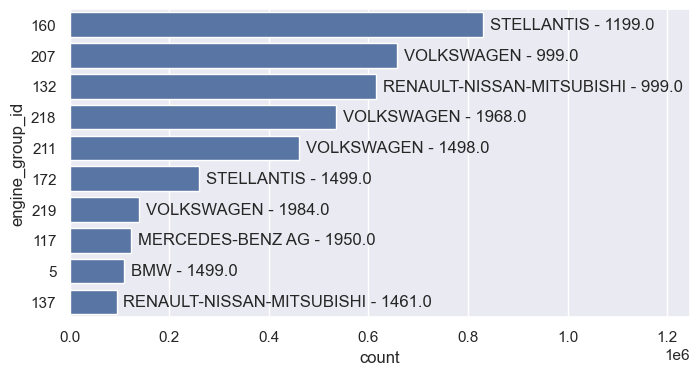

In [36]:
top_10 = data.drop_duplicates(subset=['manufacturer', 'engine_size_cm3']).join(
    group_ids.value_counts(sort=True)[:10],
    on='engine_group_id', how='right', validate='one_to_one'
).sort_values(by='count', ascending=False)
group_order = top_10.engine_group_id
group_desc = top_10.manufacturer.str.cat(top_10.engine_size_cm3.astype('string'), sep=" - ")
fig, ax = plt.subplots(figsize=[8, 4])
sns.barplot(top_10, x='count', y='engine_group_id', order=group_order, orient='h', ax=ax)
ax.bar_label(ax.containers[0], labels=group_desc, padding=5)
ax.margins(x=0.5)

In [37]:
data[data.engine_group_id == 218].sample(5, random_state=123)

,manufacturer,brand,model,mass_kg,fuel_type,fuel_mode,engine_size_cm3,engine_power_kw,engine_group_id,fuel_cons_l_100km
id,,,,,,,,,,
132802162,VOLKSWAGEN,VOLKSWAGEN,GOLF,1463.0,diesel,M,1968.0,85.0,218,4.5
131364674,VOLKSWAGEN,SEAT,SEAT LEON SP,1516.0,diesel,M,1968.0,110.0,218,4.6
130491744,VOLKSWAGEN,VOLKSWAGEN,GOLF,1441.0,diesel,M,1968.0,110.0,218,4.4
130633173,VOLKSWAGEN,VOLKSWAGEN,GOLF,1451.0,diesel,M,1968.0,110.0,218,4.6
128569987,VOLKSWAGEN,VOLKSWAGEN,T-ROC,1455.0,diesel,M,1968.0,110.0,218,4.9


Finally, we perform the split and write it to disk.

In [38]:
train_indx, test_indx = next(
    GroupShuffleSplit(test_size=0.2, random_state=123).split(data, groups=data.engine_group_id)
)
train_data, test_data = data.iloc[train_indx], data.iloc[test_indx]

print(f"In total there are {len(data)} records "
      f"and {data.engine_group_id.nunique()} unique groups")
print(f"The train set contains {len(train_data)} records "
      f"and {train_data.engine_group_id.nunique()} unique groups")
print(f"The test set contains {len(test_data)} records "
      f"and {test_data.engine_group_id.nunique()} unique groups")

In total there are 5151657 records and 235 unique groups
The train set contains 4150263 records and 188 unique groups
The test set contains 1001394 records and 47 unique groups


In [39]:
train_data.to_parquet("../data/train.parquet", compression='brotli')
test_data.to_parquet("../data/test.parquet", compression='brotli')